<a href="https://colab.research.google.com/github/kaisei3506/Prediction-of-E-commerce-Users/blob/main/lgbm_xgb_cat_train_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import holidays

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Kaggle/Prediction_of_E-commerce_Users/train_df.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle/Prediction_of_E-commerce_Users/test_df.csv')

In [4]:
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])
train = train.set_index('datetime')
test = test.set_index('datetime')

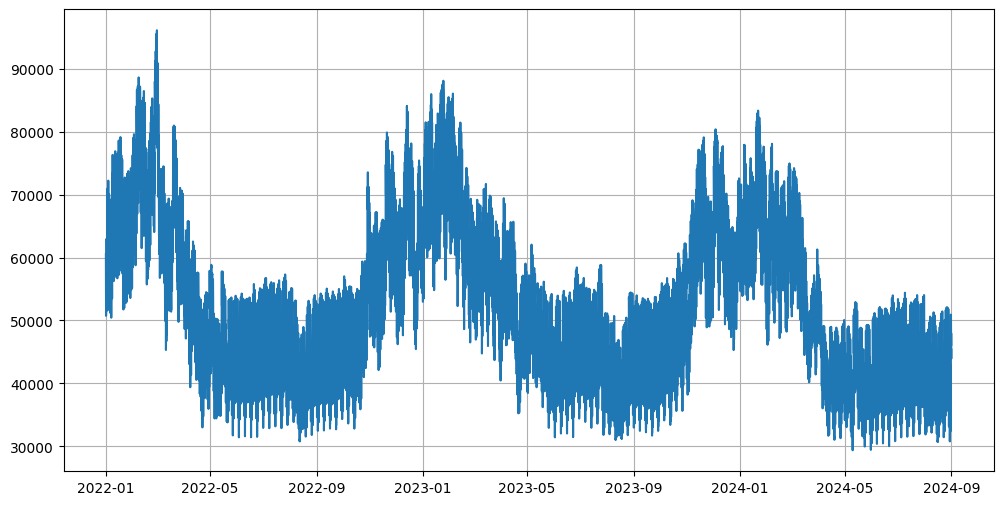

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(train['e_users'])
plt.grid()
plt.show()

In [6]:
'''
# STL分解
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(train['e_users'], model='additive', period=24*7)
fig, ax = plt.subplots(4, 1, figsize=(12, 10))
decomposition.trend.plot(ax=ax[0])
ax[0].set_title('Trend')
decomposition.seasonal.plot(ax=ax[1])
ax[1].set_title('Seasonal')
decomposition.resid.plot(ax=ax[2])
ax[2].set_title('Residual')
decomposition.observed.plot(ax=ax[3])
ax[3].set_title('Observed')
plt.tight_layout()
plt.show()
'''

"\n# STL分解\nfrom statsmodels.tsa.seasonal import seasonal_decompose\n\ndecomposition = seasonal_decompose(train['e_users'], model='additive', period=24*7)\nfig, ax = plt.subplots(4, 1, figsize=(12, 10))\ndecomposition.trend.plot(ax=ax[0])\nax[0].set_title('Trend')\ndecomposition.seasonal.plot(ax=ax[1])\nax[1].set_title('Seasonal')\ndecomposition.resid.plot(ax=ax[2])\nax[2].set_title('Residual')\ndecomposition.observed.plot(ax=ax[3])\nax[3].set_title('Observed')\nplt.tight_layout()\nplt.show()\n"

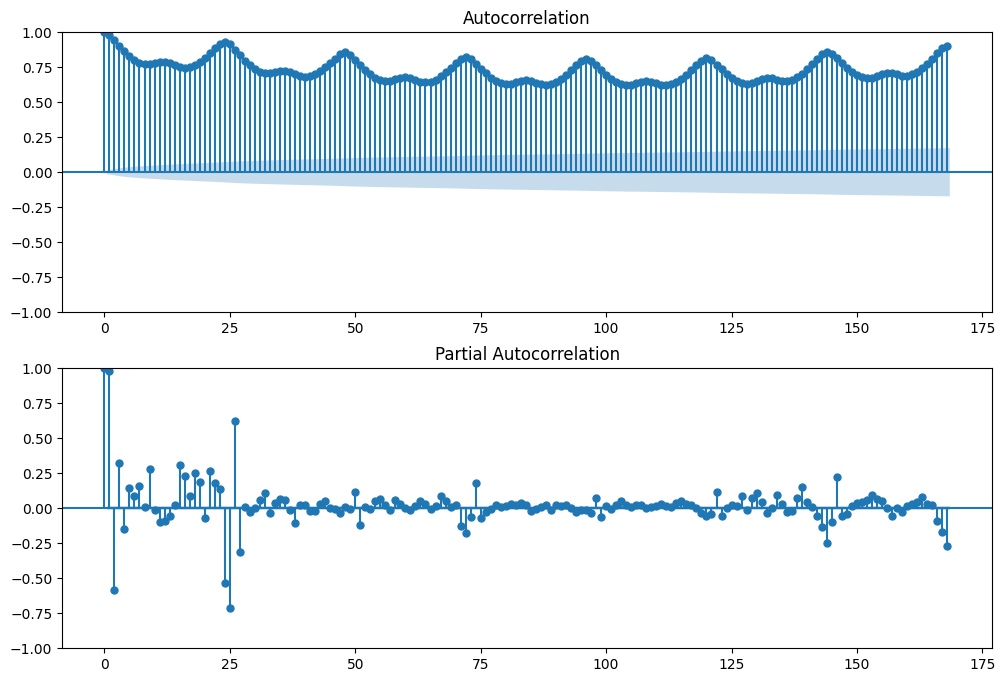

In [7]:
# 自己相関と偏自己相関
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train['e_users'], ax=ax[0], lags=24*7)
plot_pacf(train['e_users'], ax=ax[1], lags=24*7)
plt.show()

In [8]:
from statsmodels.tsa.stattools import acf

acf_values = acf(train['e_users'], nlags=100)
best_lag = (acf_values > 0.2).argmax()  # 相関が 0.2 を下回る最小のラグ
print(f"推奨ラグ: {best_lag}")


推奨ラグ: 0


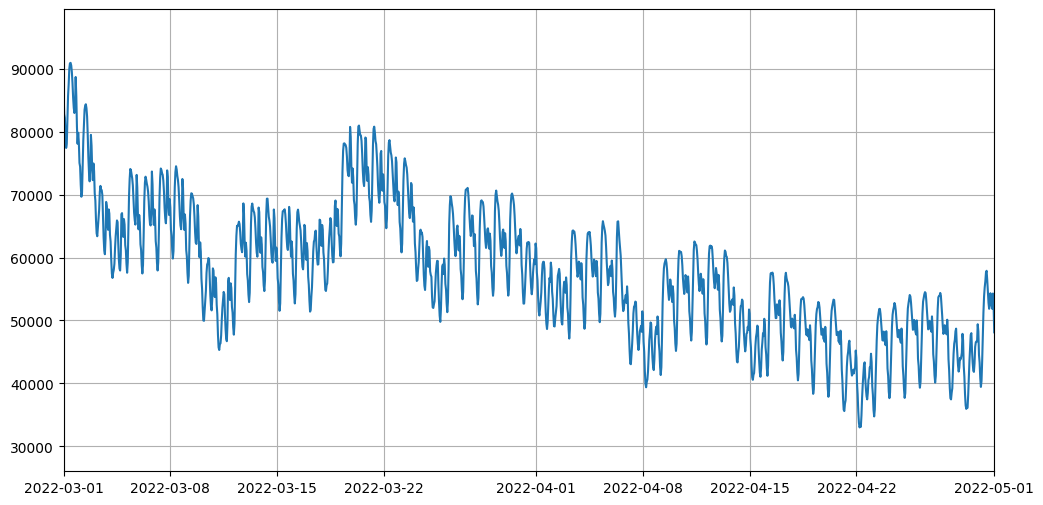

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(train['e_users'])
plt.xlim(pd.to_datetime('2022-03-01'), pd.to_datetime('2022-05-01'))
plt.grid()
plt.show()

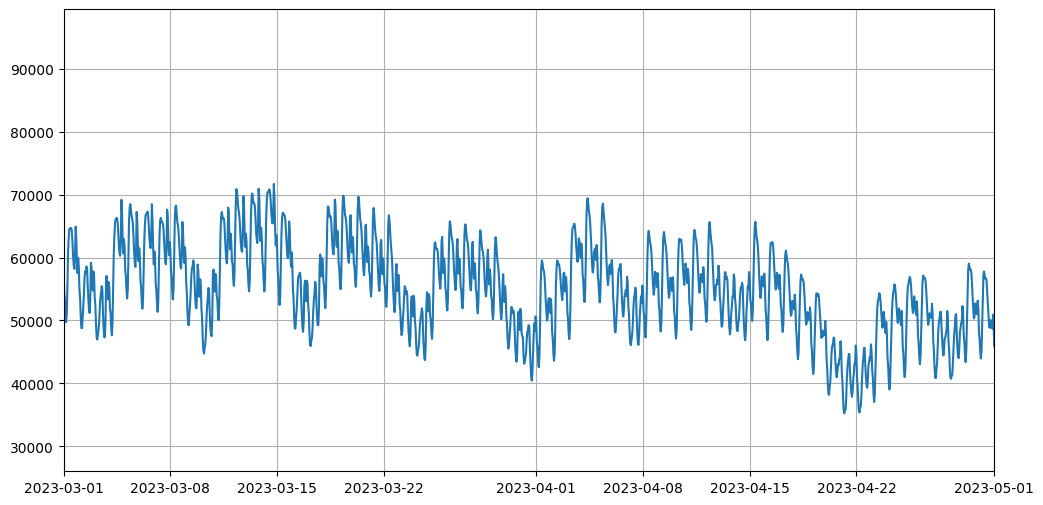

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(train['e_users'])
plt.xlim(pd.to_datetime('2023-03-01'), pd.to_datetime('2023-05-01'))
plt.grid()
plt.show()

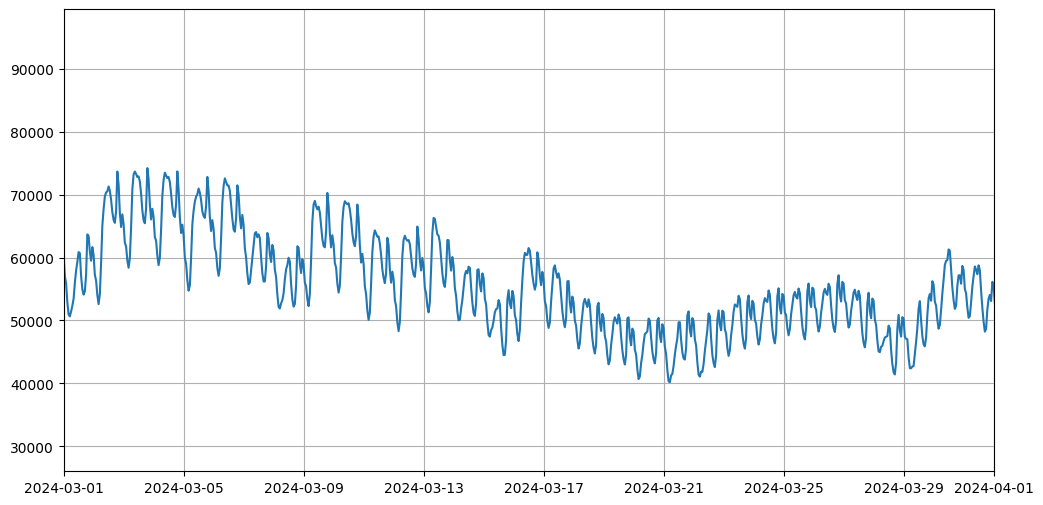

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(train['e_users'])
plt.xlim(pd.to_datetime('2024-03-01'), pd.to_datetime('2024-04-01'))
plt.grid()
plt.show()

1年くらいの周期あり？

In [12]:
df = pd.concat([train, test])
df

,e_users,promotion_1,promotion_2,promotion_3
datetime,,,,
2022-01-01 00:00:00,60545.0,11.67,95.28,80.76
2022-01-01 01:00:00,57890.0,11.33,93.25,80.81
2022-01-01 02:00:00,57021.0,11.01,91.23,80.85
2022-01-01 03:00:00,54162.0,10.82,89.40,80.89
2022-01-01 04:00:00,51772.0,10.80,88.14,80.94
...,...,...,...,...
2024-12-31 19:00:00,NaN,7.95,91.67,83.91
2024-12-31 20:00:00,NaN,7.62,91.82,85.29
2024-12-31 21:00:00,NaN,8.58,91.85,86.35


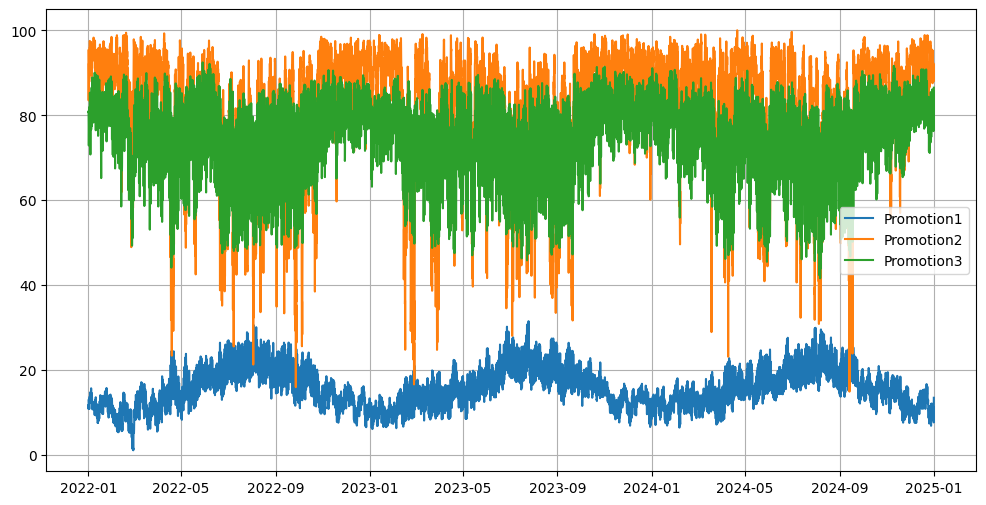

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df['promotion_1'], label='Promotion1')
plt.plot(df['promotion_2'], label='Promotion2')
plt.plot(df['promotion_3'], label='Promotion3')
plt.legend()
plt.grid()
plt.show()

In [14]:
def engineer(df_old: pd.DataFrame, is_lstm: bool = False) -> pd.DataFrame:

  df = df_old.copy()

  df['p2/p1'] = df['promotion_2'] / df['promotion_1']
  df['p3/p1'] = df['promotion_3'] / df['promotion_1']
  df['p3/p2'] = df['promotion_3'] / df['promotion_2']
  df['p1mulp2'] = df['promotion_1'] * df['promotion_2']
  df['p3mulp1'] = df['promotion_1'] * df['promotion_3']
  df['p2mulp3'] = df['promotion_2'] * df['promotion_3']

  if is_lstm==False:

    for i in range(24):
      df[f'p1_shift{i+1}h'] = df['promotion_1'].shift(i+1)
      df[f'p2_shift{i+1}h'] = df['promotion_2'].shift(i+1)
      df[f'p3_shift{i+1}h'] = df['promotion_3'].shift(i+1)
      df[f'p3mulp1_shift{i+1}h'] = df['p3mulp1'].shift(i+1)

    for i in range(7):
      df[f'p1_shift{i+1}d'] = df['promotion_1'].shift(24*(i+1))
      df[f'p2_shift{i+1}d'] = df['promotion_2'].shift(24*(i+1))
      df[f'p3_shift{i+1}d'] = df['promotion_3'].shift(24*(i+1))
      df[f'p3mulp1_shift{i+1}d'] = df['p3mulp1'].shift(24*(i+1))

    for i in range(4):
      df[f'p1_shift{i+1}w'] = df['promotion_1'].shift(24*7*(i+1))
      df[f'p2_shift{i+1}w'] = df['promotion_2'].shift(24*7*(i+1))
      df[f'p3_shift{i+1}w'] = df['promotion_3'].shift(24*7*(i+1))
      df[f'p3mulp1_shift{i+1}w'] = df['p3mulp1'].shift(24*7*(i+1))


  df['sin_dayofyear'] = np.sin(2 * np.pi * df.index.dayofyear / 366)
  df['cos_dayofyear'] = np.cos(2 * np.pi * df.index.dayofyear / 366)
  df['sin_dayofmonth'] = np.sin(2 * np.pi * df.index.day / 31)
  df['cos_dayofmonth'] = np.cos(2 * np.pi * df.index.day / 31)
  df['sin_dayofweek'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
  df['cos_dayofweek'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
  df['sin_hour'] = np.sin(2 * np.pi * df.index.hour / 24)
  df['cos_hour'] = np.cos(2 * np.pi * df.index.hour / 24)

  #df['march_april'] = df.index.month.isin([3, 4]).astype(int)

  jp_holidays = holidays.Japan()
  #df['is_jp_holiday'] = df.index.to_series().apply(lambda x: x in jp_holidays).astype(int)

  usa_holidays = holidays.US()
  df['is_usa_holiday'] = df.index.to_series().apply(lambda x: x in usa_holidays).astype(int)

  eu_holidays = holidays.EuropeanCentralBank()
  df['is_eu_holiday'] = df.index.to_series().apply(lambda x: x in eu_holidays).astype(int)

  china_holidays = holidays.China()
  df['is_china_holiday'] = df.index.to_series().apply(lambda x: x in china_holidays).astype(int)

  india_holidays = holidays.India()
  df['is_india_holiday'] = df.index.to_series().apply(lambda x: x in india_holidays).astype(int)

  df['log_e_users'] = np.log(df['e_users'])
  df = df.drop('e_users', axis=1)

  # log_e_users以外のカラムの欠損値を削除
  temp = df.dropna(subset=df.columns.drop('log_e_users'))
  df = temp.copy()


  return df

In [15]:
engineered_df = engineer(df)
engineered_df

,promotion_1,promotion_2,promotion_3,p2/p1,p3/p1,p3/p2,p1mulp2,p3mulp1,p2mulp3,p1_shift1h,...,cos_dayofmonth,sin_dayofweek,cos_dayofweek,sin_hour,cos_hour,is_usa_holiday,is_eu_holiday,is_china_holiday,is_india_holiday,log_e_users
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-29 00:00:00,10.28,95.49,88.68,9.288911,8.626459,0.928684,981.6372,911.6304,8468.0532,10.57,...,0.918958,-0.974928,-0.222521,0.000000,1.000000,0,0,0,0,11.030606
2022-01-29 01:00:00,10.23,95.53,88.53,9.338221,8.653959,0.926725,977.2719,905.6619,8457.2709,10.28,...,0.918958,-0.974928,-0.222521,0.258819,0.965926,0,0,0,0,10.977209
2022-01-29 02:00:00,10.27,95.57,88.38,9.305745,8.605648,0.924767,981.5039,907.6626,8446.4766,10.23,...,0.918958,-0.974928,-0.222521,0.500000,0.866025,0,0,0,0,10.960931
2022-01-29 03:00:00,10.24,95.54,88.27,9.330078,8.620117,0.923906,978.3296,903.8848,8433.3158,10.27,...,0.918958,-0.974928,-0.222521,0.707107,0.707107,0,0,0,0,10.913924
2022-01-29 04:00:00,10.07,95.32,88.28,9.465740,8.766634,0.926144,959.8724,888.9796,8414.8496,10.24,...,0.918958,-0.974928,-0.222521,0.866025,0.500000,0,0,0,0,10.888707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,7.95,91.67,83.91,11.530818,10.554717,0.915349,728.7765,667.0845,7692.0297,8.89,...,1.000000,0.781831,0.623490,-0.965926,0.258819,0,0,0,0,NaN
2024-12-31 20:00:00,7.62,91.82,85.29,12.049869,11.192913,0.928883,699.6684,649.9098,7831.3278,7.95,...,1.000000,0.781831,0.623490,-0.866025,0.500000,0,0,0,0,NaN
2024-12-31 21:00:00,8.58,91.85,86.35,10.705128,10.064103,0.940120,788.0730,740.8830,7931.2475,7.62,...,1.000000,0.781831,0.623490,-0.707107,0.707107,0,0,0,0,NaN


In [16]:
temp = engineered_df.copy()

train_engineered = temp[:'2023-12-31']
valid_engineered = temp['2024-01-01':'2024-08-31']
test_engineered = temp['2024-09-01':]

engineered_df_time = engineer(df_old=df, is_lstm=True)
train_time = engineered_df_time[:'2023-12-31']
valid_time = engineered_df_time['2024-01-01':'2024-08-31']
test_time = engineered_df_time['2024-09-01':]

train_valid_time = pd.concat([train_time, valid_time])

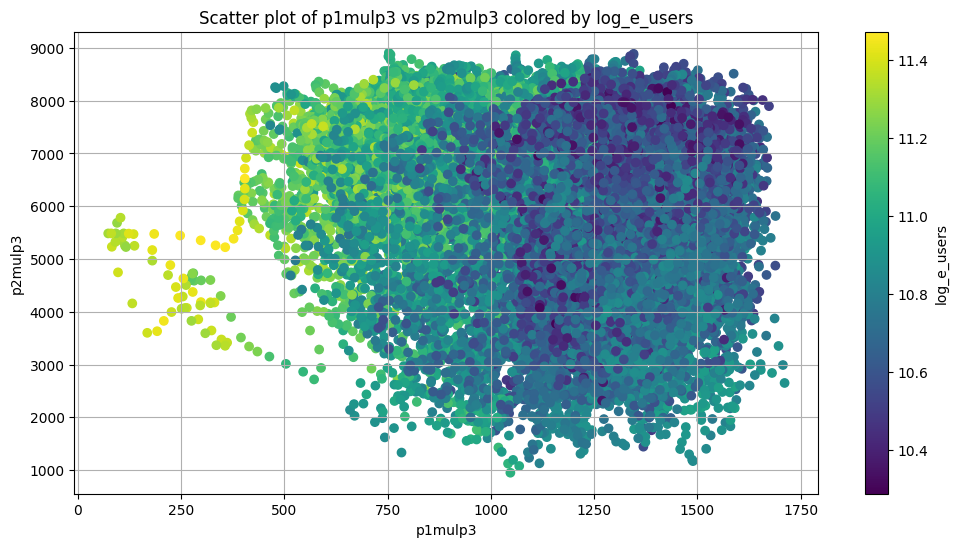

In [17]:
# p1mulp3とp2mulp3の関係をlog_e_usersの値に応じて色を変えてプロット
plt.figure(figsize=(12, 6))
scatter = plt.scatter(temp['p3mulp1'], temp['p2mulp3'], c=temp['log_e_users'], cmap='viridis')
plt.colorbar(scatter, label='log_e_users')  # カラーバーを追加
plt.grid()
plt.xlabel('p1mulp3')
plt.ylabel('p2mulp3')
plt.title('Scatter plot of p1mulp3 vs p2mulp3 colored by log_e_users')
plt.show()


In [18]:
'''
temp_columns = train.columns.drop('log_e_users')

for i in range(len(temp_columns)):
  for j in range(i+1, len(temp_columns)):
    plt.figure(figsize=(12, 6))
    plt.scatter(train[temp_columns[i]], train[temp_columns[j]], c=train['log_e_users'], cmap='viridis')
    plt.colorbar()
    plt.xlabel(temp_columns[i])
    plt.ylabel(temp_columns[j])
    plt.title(f'Scatter plot of {temp_columns[i]} vs {temp_columns[j]} colored by log_e_users')
    plt.show()
'''

"\ntemp_columns = train.columns.drop('log_e_users')\n\nfor i in range(len(temp_columns)):\n  for j in range(i+1, len(temp_columns)):\n    plt.figure(figsize=(12, 6))\n    plt.scatter(train[temp_columns[i]], train[temp_columns[j]], c=train['log_e_users'], cmap='viridis')\n    plt.colorbar()\n    plt.xlabel(temp_columns[i])\n    plt.ylabel(temp_columns[j])\n    plt.title(f'Scatter plot of {temp_columns[i]} vs {temp_columns[j]} colored by log_e_users')\n    plt.show()\n"

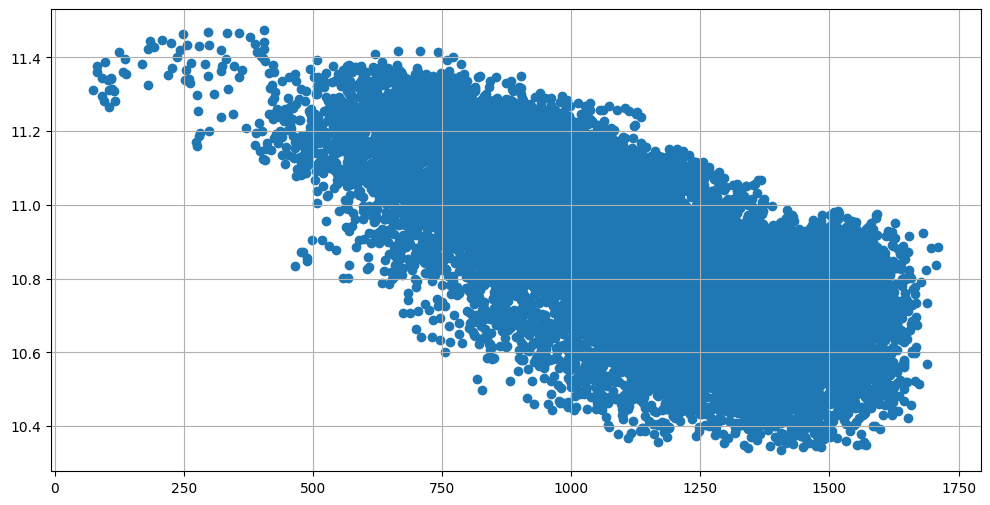

In [19]:
# p1mulp3とe_usersの関係
plt.figure(figsize=(12, 6))
plt.scatter(train_engineered['p3mulp1'], train_engineered['log_e_users'])
plt.grid()
plt.show()

In [20]:
X_train = train_engineered.drop('log_e_users', axis=1)
y_train = train_engineered['log_e_users']
X_valid = valid_engineered.drop('log_e_users', axis=1)
y_valid = valid_engineered['log_e_users']
X_test = test_engineered.drop('log_e_users', axis=1)

In [21]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_valid_scaled = X_scaler.transform(X_valid)
X_test_scaled = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_valid_scaled = y_scaler.transform(y_valid.values.reshape(-1, 1))

In [22]:
X_train_time = train_time.drop('log_e_users', axis=1)
y_train_time = train_time['log_e_users']
X_valid_time = valid_time.drop('log_e_users', axis=1)
y_valid_time = valid_time['log_e_users']
X_test_time = test_time.drop('log_e_users', axis=1)

X_train_valid_time = train_valid_time.drop('log_e_users', axis=1)
y_train_valid_time = train_valid_time['log_e_users']

In [23]:
from sklearn.preprocessing import StandardScaler

# ラグ特徴量なし、検証あり
X_scaler_time = StandardScaler()
X_train_scaled_time = X_scaler_time.fit_transform(X_train_time)
X_valid_scaled_time = X_scaler_time.transform(X_valid_time)
X_test_scaled_time = X_scaler_time.transform(X_test_time)

y_scaler_time = StandardScaler()
y_train_scaled_time = y_scaler_time.fit_transform(y_train.values.reshape(-1, 1))
y_valid_scaled_time = y_scaler_time.transform(y_valid.values.reshape(-1, 1))

# ラグ特徴量なし、検証なし
X_scaler_train_valid_time = StandardScaler()
X_train_valid_scaled_time = X_scaler_train_valid_time.fit_transform(X_train_valid_time)
X_test_scaled_time_novalid = X_scaler_train_valid_time.transform(X_test_time)

y_scaler_time_novalid = StandardScaler()
y_train_valid_scaled_time = y_scaler_time_novalid.fit_transform(y_train_valid_time.values.reshape(-1, 1))

In [24]:
'''
from statsmodels.tsa.statespace.sarimax import SARIMAX

y_sarimax = y_train_valid_time
exog = X_train_valid_scaled_time

sarimax_model = SARIMAX(y_sarimax,
                order=(1, 1, 1),        # (p, d, q)
                seasonal_order=(1, 1, 1, 24),  # (P, D, Q, s)
                exog=exog,
                trend='c',
                enforce_stationarity=False,
                enforce_invertibility=False)
result = sarimax_model.fit(maxiter=20, disp=1)
print(result.summary())
'''

"\nfrom statsmodels.tsa.statespace.sarimax import SARIMAX\n\ny_sarimax = y_train_valid_time\nexog = X_train_valid_scaled_time\n\nsarimax_model = SARIMAX(y_sarimax,\n                order=(1, 1, 1),        # (p, d, q)\n                seasonal_order=(1, 1, 1, 24),  # (P, D, Q, s)\n                exog=exog,\n                trend='c',\n                enforce_stationarity=False,\n                enforce_invertibility=False)\nresult = sarimax_model.fit(maxiter=20, disp=1)\nprint(result.summary())\n"

In [25]:
'''
steps = len(test_time)
sarimax_test_pred = result.forecast(steps=steps, exog=X_test_scaled_time_novalid)

# sarimax_test_predのプロット
plt.figure(figsize=(12, 6))
plt.plot(index=test_time.index, value=sarimax_test_pred, label='SARIMAX Forecast')
plt.legend()
plt.grid()
plt.show()
'''

"\nsteps = len(test_time)\nsarimax_test_pred = result.forecast(steps=steps, exog=X_test_scaled_time_novalid)\n\n# sarimax_test_predのプロット\nplt.figure(figsize=(12, 6))\nplt.plot(index=test_time.index, value=sarimax_test_pred, label='SARIMAX Forecast')\nplt.legend()\nplt.grid()\nplt.show()\n"

In [26]:
'''
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# Initialize Prophet model
prophet_model = Prophet(
    changepoint_prior_scale=0.5,
    yearly_seasonality=True,  # 年単位の季節性は無効化（短期予測では不要）
    weekly_seasonality=True,  # 週単位の季節性を追加
    daily_seasonality=True    # 日単位の季節性を追加
)

# 外生変数（追加回帰変数）をモデルに追加
prophet_model.add_regressor('promotion_1')
prophet_model.add_regressor('promotion_2')
prophet_model.add_regressor('promotion_3')
# 1時間ごとの周期性を追加（24時間周期で変動するものを考慮）
prophet_model.add_seasonality(name='hourly', period=24, fourier_order=8)

prophet_train = pd.DataFrame()
prophet_train['ds'] = train_engineered.index
prophet_train['y'] = train_engineered['log_e_users'].values
prophet_train['promotion_1'] = train_engineered['promotion_1'].values
prophet_train['promotion_2'] = train_engineered['promotion_2'].values
prophet_train['promotion_3'] = train_engineered['promotion_3'].values
prophet_train

# Train the model
prophet_model.fit(prophet_train)
'''

"\nfrom prophet import Prophet\nfrom sklearn.metrics import mean_squared_error\n\n# Initialize Prophet model\nprophet_model = Prophet(\n    changepoint_prior_scale=0.5,\n    yearly_seasonality=True,  # 年単位の季節性は無効化（短期予測では不要）\n    weekly_seasonality=True,  # 週単位の季節性を追加\n    daily_seasonality=True    # 日単位の季節性を追加\n)\n\n# 外生変数（追加回帰変数）をモデルに追加\nprophet_model.add_regressor('promotion_1')\nprophet_model.add_regressor('promotion_2')\nprophet_model.add_regressor('promotion_3')\n# 1時間ごとの周期性を追加（24時間周期で変動するものを考慮）\nprophet_model.add_seasonality(name='hourly', period=24, fourier_order=8)\n\nprophet_train = pd.DataFrame()\nprophet_train['ds'] = train_engineered.index\nprophet_train['y'] = train_engineered['log_e_users'].values\nprophet_train['promotion_1'] = train_engineered['promotion_1'].values\nprophet_train['promotion_2'] = train_engineered['promotion_2'].values\nprophet_train['promotion_3'] = train_engineered['promotion_3'].values\nprophet_train\n\n# Train the model\nprophet_model.fit(prophet_tra

In [27]:
'''
# Generate future dataframe for validation set
future_valid_test = prophet_model.make_future_dataframe(periods=len(pd.concat([valid_engineered, test_engineered])), freq='H')

# 未来のデータに外生変数を追加（予測時にも必要）
# future_valid_test に valid_engineered, test_engineered の temperature をマージ
train_engineered = train_engineered.reset_index().rename(columns={'datetime': 'ds'})
valid_engineered = valid_engineered.reset_index().rename(columns={'datetime': 'ds'})
test_engineered = test_engineered.reset_index().rename(columns={'datetime': 'ds'})

future_valid_test = future_valid_test.merge(
    pd.concat([train_engineered[['ds', 'promotion_1', 'promotion_2', 'promotion_3']], valid_engineered[['ds', 'promotion_1', 'promotion_2', 'promotion_3']], test_engineered[['ds', 'promotion_1', 'promotion_2', 'promotion_3']]]),
    on='ds',
    how='left'
)

train_engineered = train_engineered.rename(columns={'ds': 'datetime'}).set_index('datetime')
valid_engineered = valid_engineered.rename(columns={'ds': 'datetime'}).set_index('datetime')
test_engineered = test_engineered.rename(columns={'ds': 'datetime'}).set_index('datetime')

forecast = prophet_model.predict(future_valid_test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
'''

"\n# Generate future dataframe for validation set\nfuture_valid_test = prophet_model.make_future_dataframe(periods=len(pd.concat([valid_engineered, test_engineered])), freq='H')\n\n# 未来のデータに外生変数を追加（予測時にも必要）\n# future_valid_test に valid_engineered, test_engineered の temperature をマージ\ntrain_engineered = train_engineered.reset_index().rename(columns={'datetime': 'ds'})\nvalid_engineered = valid_engineered.reset_index().rename(columns={'datetime': 'ds'})\ntest_engineered = test_engineered.reset_index().rename(columns={'datetime': 'ds'})\n\nfuture_valid_test = future_valid_test.merge(\n    pd.concat([train_engineered[['ds', 'promotion_1', 'promotion_2', 'promotion_3']], valid_engineered[['ds', 'promotion_1', 'promotion_2', 'promotion_3']], test_engineered[['ds', 'promotion_1', 'promotion_2', 'promotion_3']]]),\n    on='ds',\n    how='left'\n)\n\ntrain_engineered = train_engineered.rename(columns={'ds': 'datetime'}).set_index('datetime')\nvalid_engineered = valid_engineered.rename(columns={'

In [28]:
# future_valid_test

In [29]:
'''
# valid_engineeredのlog_e_usersとRMSEを計算
print(f'Valid RMSE: {np.sqrt(mean_squared_error(valid_engineered["log_e_users"], forecast["yhat"][-len(valid_engineered):]))}')
'''

'\n# valid_engineeredのlog_e_usersとRMSEを計算\nprint(f\'Valid RMSE: {np.sqrt(mean_squared_error(valid_engineered["log_e_users"], forecast["yhat"][-len(valid_engineered):]))}\')\n'

In [30]:
# fig1 = prophet_model.plot(forecast)

In [31]:
# fig2 = prophet_model.plot_components(forecast)


In [32]:
X_train

,promotion_1,promotion_2,promotion_3,p2/p1,p3/p1,p3/p2,p1mulp2,p3mulp1,p2mulp3,p1_shift1h,...,sin_dayofmonth,cos_dayofmonth,sin_dayofweek,cos_dayofweek,sin_hour,cos_hour,is_usa_holiday,is_eu_holiday,is_china_holiday,is_india_holiday
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-29 00:00:00,10.28,95.49,88.68,9.288911,8.626459,0.928684,981.6372,911.6304,8468.0532,10.57,...,-3.943559e-01,0.918958,-0.974928,-0.222521,0.000000,1.000000,0,0,0,0
2022-01-29 01:00:00,10.23,95.53,88.53,9.338221,8.653959,0.926725,977.2719,905.6619,8457.2709,10.28,...,-3.943559e-01,0.918958,-0.974928,-0.222521,0.258819,0.965926,0,0,0,0
2022-01-29 02:00:00,10.27,95.57,88.38,9.305745,8.605648,0.924767,981.5039,907.6626,8446.4766,10.23,...,-3.943559e-01,0.918958,-0.974928,-0.222521,0.500000,0.866025,0,0,0,0
2022-01-29 03:00:00,10.24,95.54,88.27,9.330078,8.620117,0.923906,978.3296,903.8848,8433.3158,10.27,...,-3.943559e-01,0.918958,-0.974928,-0.222521,0.707107,0.707107,0,0,0,0
2022-01-29 04:00:00,10.07,95.32,88.28,9.465740,8.766634,0.926144,959.8724,888.9796,8414.8496,10.24,...,-3.943559e-01,0.918958,-0.974928,-0.222521,0.866025,0.500000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,9.63,88.10,84.76,9.148494,8.801661,0.962089,848.4030,816.2388,7467.3560,10.03,...,-2.449294e-16,1.000000,-0.781831,0.623490,-0.965926,0.258819,0,0,0,0
2023-12-31 20:00:00,9.43,88.25,85.58,9.358431,9.075292,0.969745,832.1975,807.0194,7552.4350,9.63,...,-2.449294e-16,1.000000,-0.781831,0.623490,-0.866025,0.500000,0,0,0,0
2023-12-31 21:00:00,9.22,88.93,86.42,9.645336,9.373102,0.971776,819.9346,796.7924,7685.3306,9.43,...,-2.449294e-16,1.000000,-0.781831,0.623490,-0.707107,0.707107,0,0,0,0


In [33]:
X_valid

,promotion_1,promotion_2,promotion_3,p2/p1,p3/p1,p3/p2,p1mulp2,p3mulp1,p2mulp3,p1_shift1h,...,sin_dayofmonth,cos_dayofmonth,sin_dayofweek,cos_dayofweek,sin_hour,cos_hour,is_usa_holiday,is_eu_holiday,is_china_holiday,is_india_holiday
datetime,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,8.38,94.83,89.08,11.316229,10.630072,0.939365,794.6754,746.4904,8447.4564,8.57,...,2.012985e-01,0.97953,0.000000,1.000000,0.000000,1.000000,1,1,1,0
2024-01-01 01:00:00,8.37,93.35,89.15,11.152927,10.651135,0.955008,781.3395,746.1855,8322.1525,8.38,...,2.012985e-01,0.97953,0.000000,1.000000,0.258819,0.965926,1,1,1,0
2024-01-01 02:00:00,8.45,91.87,89.21,10.872189,10.557396,0.971046,776.3015,753.8245,8195.7227,8.37,...,2.012985e-01,0.97953,0.000000,1.000000,0.500000,0.866025,1,1,1,0
2024-01-01 03:00:00,8.51,91.18,89.25,10.714454,10.487662,0.978833,775.9418,759.5175,8137.8150,8.45,...,2.012985e-01,0.97953,0.000000,1.000000,0.707107,0.707107,1,1,1,0
2024-01-01 04:00:00,8.50,92.84,89.19,10.922353,10.492941,0.960685,789.1400,758.1150,8280.3996,8.51,...,2.012985e-01,0.97953,0.000000,1.000000,0.866025,0.500000,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31 19:00:00,18.52,73.52,66.95,3.969762,3.615011,0.910637,1361.5904,1239.9140,4922.1640,19.44,...,-2.449294e-16,1.00000,-0.974928,-0.222521,-0.965926,0.258819,0,0,0,0
2024-08-31 20:00:00,17.53,71.67,71.15,4.088420,4.058756,0.992745,1256.3751,1247.2595,5099.3205,18.52,...,-2.449294e-16,1.00000,-0.974928,-0.222521,-0.866025,0.500000,0,0,0,0
2024-08-31 21:00:00,16.67,70.77,74.84,4.245351,4.489502,1.057510,1179.7359,1247.5828,5296.4268,17.53,...,-2.449294e-16,1.00000,-0.974928,-0.222521,-0.707107,0.707107,0,0,0,0


In [34]:
X_train_valid = pd.concat([X_train, X_valid])
X_train_valid

,promotion_1,promotion_2,promotion_3,p2/p1,p3/p1,p3/p2,p1mulp2,p3mulp1,p2mulp3,p1_shift1h,...,sin_dayofmonth,cos_dayofmonth,sin_dayofweek,cos_dayofweek,sin_hour,cos_hour,is_usa_holiday,is_eu_holiday,is_china_holiday,is_india_holiday
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-29 00:00:00,10.28,95.49,88.68,9.288911,8.626459,0.928684,981.6372,911.6304,8468.0532,10.57,...,-3.943559e-01,0.918958,-0.974928,-0.222521,0.000000,1.000000,0,0,0,0
2022-01-29 01:00:00,10.23,95.53,88.53,9.338221,8.653959,0.926725,977.2719,905.6619,8457.2709,10.28,...,-3.943559e-01,0.918958,-0.974928,-0.222521,0.258819,0.965926,0,0,0,0
2022-01-29 02:00:00,10.27,95.57,88.38,9.305745,8.605648,0.924767,981.5039,907.6626,8446.4766,10.23,...,-3.943559e-01,0.918958,-0.974928,-0.222521,0.500000,0.866025,0,0,0,0
2022-01-29 03:00:00,10.24,95.54,88.27,9.330078,8.620117,0.923906,978.3296,903.8848,8433.3158,10.27,...,-3.943559e-01,0.918958,-0.974928,-0.222521,0.707107,0.707107,0,0,0,0
2022-01-29 04:00:00,10.07,95.32,88.28,9.465740,8.766634,0.926144,959.8724,888.9796,8414.8496,10.24,...,-3.943559e-01,0.918958,-0.974928,-0.222521,0.866025,0.500000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31 19:00:00,18.52,73.52,66.95,3.969762,3.615011,0.910637,1361.5904,1239.9140,4922.1640,19.44,...,-2.449294e-16,1.000000,-0.974928,-0.222521,-0.965926,0.258819,0,0,0,0
2024-08-31 20:00:00,17.53,71.67,71.15,4.088420,4.058756,0.992745,1256.3751,1247.2595,5099.3205,18.52,...,-2.449294e-16,1.000000,-0.974928,-0.222521,-0.866025,0.500000,0,0,0,0
2024-08-31 21:00:00,16.67,70.77,74.84,4.245351,4.489502,1.057510,1179.7359,1247.5828,5296.4268,17.53,...,-2.449294e-16,1.000000,-0.974928,-0.222521,-0.707107,0.707107,0,0,0,0


In [35]:
y_train_valid = pd.concat([y_train, y_valid])
y_train_valid

,log_e_users
datetime,
2022-01-29 00:00:00,11.030606
2022-01-29 01:00:00,10.977209
2022-01-29 02:00:00,10.960931
2022-01-29 03:00:00,10.913924
2022-01-29 04:00:00,10.888707
...,...
2024-08-31 19:00:00,10.778540
2024-08-31 20:00:00,10.756093
2024-08-31 21:00:00,10.735592


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38593
[LightGBM] [Info] Number of data points in the train set: 22704, number of used features: 161
[LightGBM] [Info] Start training from score 10.843545
LGBM Train RMSE: 0.01831045135519508
LGBM Valid RMSE: 0.019174709106406607


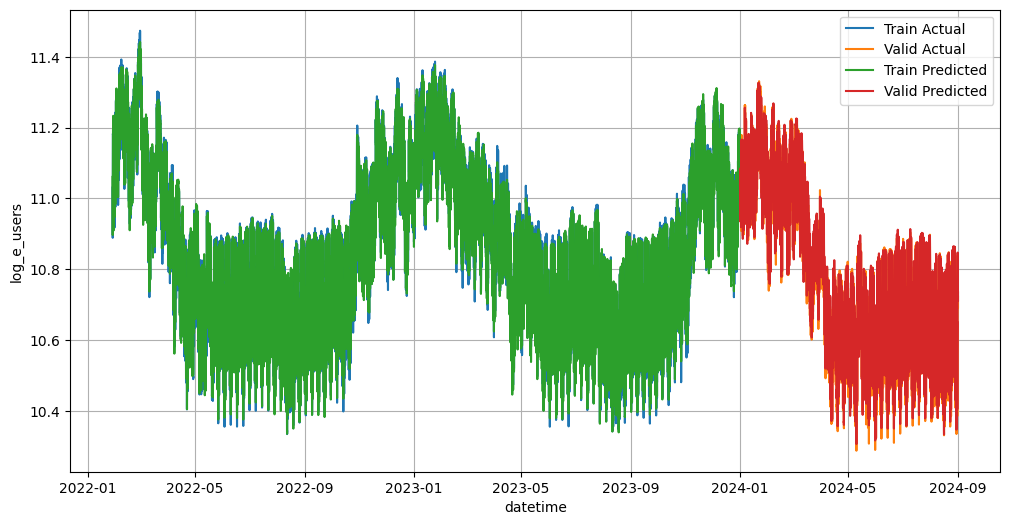

In [36]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error


params = {'objective': 'regression',
          'metric': 'rmse',
          'random_state': 42,
          'n_estimators': 1400,
          'learning_rate': 0.01
          }
lgbm_model = LGBMRegressor(**params)
lgbm_model.fit(X_train_valid, y_train_valid)

lgbm_train_pred = lgbm_model.predict(X_train)
lgbm_valid_pred = lgbm_model.predict(X_valid)
lgbm_test_pred = lgbm_model.predict(X_test)

print(f'LGBM Train RMSE: {np.sqrt(mean_squared_error(y_train, lgbm_train_pred))}')
print(f'LGBM Valid RMSE: {np.sqrt(mean_squared_error(y_valid, lgbm_valid_pred))}')

plt.figure(figsize=(12, 6))

sns.lineplot(x=X_train.index, y=y_train, label='Train Actual')
sns.lineplot(x=X_valid.index, y=y_valid, label='Valid Actual')
sns.lineplot(x=X_train.index, y=lgbm_train_pred, label='Train Predicted')
sns.lineplot(x=X_valid.index, y=lgbm_valid_pred, label='Valid Predicted')

plt.grid()
plt.legend()
plt.show()

Train_RMSE: 0.013171852573646184
Valid_RMSE: 0.014756671536620154


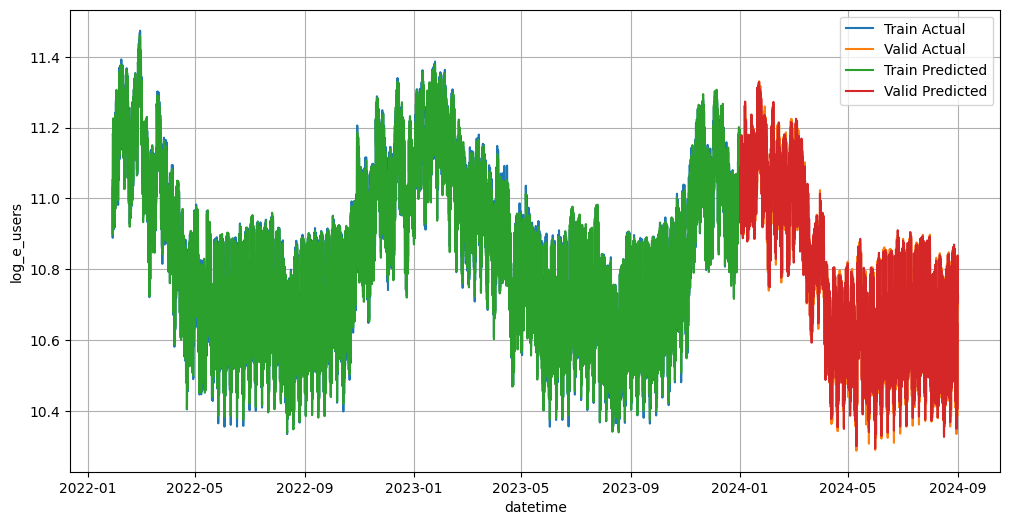

In [37]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


params = {'metric': 'rmse',
          'random_state': 42,
          'n_estimators': 2000,
          'learning_rate': 0.01}
xgb_model = XGBRegressor(**params)
xgb_model.fit(X_train_valid, y_train_valid)

xgb_train_pred = xgb_model.predict(X_train)
xgb_valid_pred = xgb_model.predict(X_valid)
xgb_test_pred = xgb_model.predict(X_test)

print(f'Train_RMSE: {np.sqrt(mean_squared_error(y_train, xgb_train_pred))}')
print(f'Valid_RMSE: {np.sqrt(mean_squared_error(y_valid, xgb_valid_pred))}')

plt.figure(figsize=(12, 6))

sns.lineplot(x=X_train.index, y=y_train, label='Train Actual')
sns.lineplot(x=X_valid.index, y=y_valid, label='Valid Actual')
sns.lineplot(x=X_train.index, y=xgb_train_pred, label='Train Predicted')
sns.lineplot(x=X_valid.index, y=xgb_valid_pred, label='Valid Predicted')

plt.grid()
plt.legend()
plt.show()

In [38]:
'''
!pip uninstall -y numpy
!pip install numpy==1.26.4 --no-cache-dir
!pip install catboost --no-cache-dir --no-deps

import numpy as np
print(np.__version__)
'''

'\n!pip uninstall -y numpy\n!pip install numpy==1.26.4 --no-cache-dir\n!pip install catboost --no-cache-dir --no-deps\n\nimport numpy as np\nprint(np.__version__)\n'

In [39]:
'''
import catboost

print(np.__version__)  # numpyのバージョン確認
print(catboost.__version__)  # catboostのバージョン確認
'''

'\nimport catboost\n\nprint(np.__version__)  # numpyのバージョン確認\nprint(catboost.__version__)  # catboostのバージョン確認\n'

In [40]:
!pip install catboost

0:	learn: 0.2202611	total: 249ms	remaining: 12m 27s
1:	learn: 0.2185151	total: 393ms	remaining: 9m 48s
2:	learn: 0.2168139	total: 473ms	remaining: 7m 52s
3:	learn: 0.2151337	total: 527ms	remaining: 6m 34s
4:	learn: 0.2134053	total: 592ms	remaining: 5m 54s
5:	learn: 0.2117931	total: 666ms	remaining: 5m 32s
6:	learn: 0.2101680	total: 772ms	remaining: 5m 30s
7:	learn: 0.2085096	total: 840ms	remaining: 5m 14s
8:	learn: 0.2068963	total: 912ms	remaining: 5m 2s
9:	learn: 0.2053271	total: 1.01s	remaining: 5m 3s
10:	learn: 0.2037704	total: 1.09s	remaining: 4m 56s
11:	learn: 0.2022493	total: 1.14s	remaining: 4m 44s
12:	learn: 0.2007443	total: 1.2s	remaining: 4m 35s
13:	learn: 0.1991541	total: 1.28s	remaining: 4m 33s
14:	learn: 0.1976826	total: 1.42s	remaining: 4m 42s
15:	learn: 0.1962300	total: 1.57s	remaining: 4m 53s
16:	learn: 0.1947971	total: 1.67s	remaining: 4m 52s
17:	learn: 0.1933459	total: 1.77s	remaining: 4m 53s
18:	learn: 0.1918803	total: 1.88s	remaining: 4m 55s
19:	learn: 0.1903643	tot

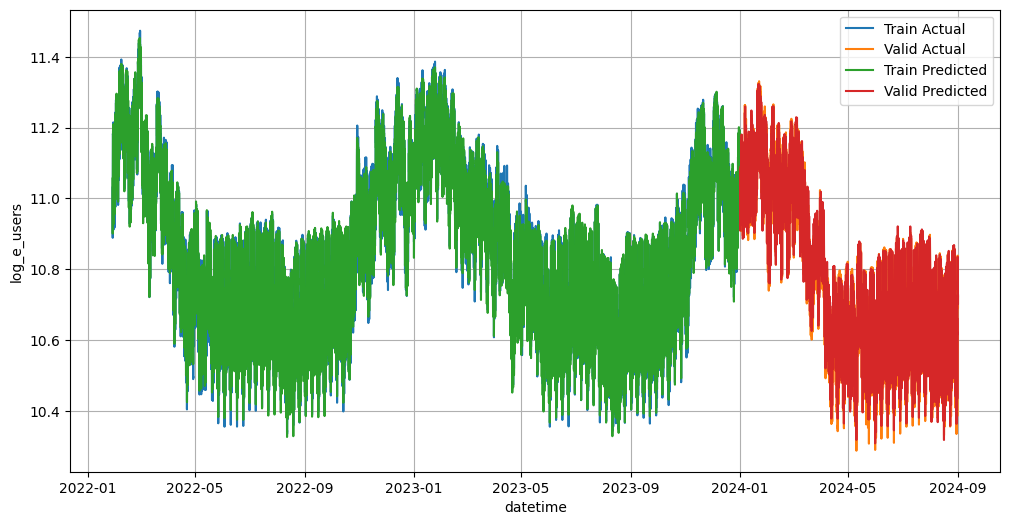

In [41]:
# catboost
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

params = {'random_state': 42,
          'iterations': 3000,
          'learning_rate': 0.01,
          'eval_metric': 'RMSE'}
cat_model = CatBoostRegressor(**params)
cat_model.fit(X_train_valid, y_train_valid)

cat_train_pred = cat_model.predict(X_train)
cat_valid_pred = cat_model.predict(X_valid)
cat_test_pred = cat_model.predict(X_test)

print(f'Train_RMSE: {np.sqrt(mean_squared_error(y_train, cat_train_pred))}')
print(f'Valid_RMSE: {np.sqrt(mean_squared_error(y_valid, cat_valid_pred))}')

plt.figure(figsize=(12, 6))

sns.lineplot(x=X_train.index, y=y_train, label='Train Actual')
sns.lineplot(x=X_valid.index, y=y_valid, label='Valid Actual')
sns.lineplot(x=X_train.index, y=cat_train_pred, label='Train Predicted')
sns.lineplot(x=X_valid.index, y=cat_valid_pred, label='Valid Predicted')

plt.grid()
plt.legend()
plt.show()

In [42]:
'''
# MLP
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

params = {'hidden_layer_sizes': (1024, 512, 256, 128, 64, 32),
          'activation': 'tanh',
          'solver': 'adam',
          'random_state': 42
}
mlp_model = MLPRegressor(**params)
mlp_model.fit(X_train_scaled, y_train_scaled)
mlp_train_pred = y_scaler.inverse_transform(mlp_model.predict(X_train_scaled).reshape(-1, 1))
mlp_valid_pred = y_scaler.inverse_transform(mlp_model.predict(X_valid_scaled).reshape(-1, 1))
mlp_test_pred = y_scaler.inverse_transform(mlp_model.predict(X_test_scaled).reshape(-1, 1))

print(f'Train_RMSE: {np.sqrt(mean_squared_error(y_train_scaled, mlp_train_pred))}')
print(f'Valid_RMSE: {np.sqrt(mean_squared_error(y_valid_scaled, mlp_valid_pred))}')

plt.figure(figsize=(12, 6))

sns.lineplot(x=X_train.index, y=y_train, label='Train Actual')
sns.lineplot(x=X_valid.index, y=y_valid, label='Valid Actual')
sns.lineplot(x=X_train.index, y=mlp_train_pred.flatten(), label='Train Predicted')
sns.lineplot(x=X_valid.index, y=mlp_valid_pred.flatten(), label='Valid Predicted')

plt.grid()
plt.legend()
plt.show()
'''

"\n# MLP\nfrom sklearn.neural_network import MLPRegressor\nfrom sklearn.metrics import mean_squared_error\n\nparams = {'hidden_layer_sizes': (1024, 512, 256, 128, 64, 32),\n          'activation': 'tanh',\n          'solver': 'adam',\n          'random_state': 42\n}\nmlp_model = MLPRegressor(**params)\nmlp_model.fit(X_train_scaled, y_train_scaled)\nmlp_train_pred = y_scaler.inverse_transform(mlp_model.predict(X_train_scaled).reshape(-1, 1))\nmlp_valid_pred = y_scaler.inverse_transform(mlp_model.predict(X_valid_scaled).reshape(-1, 1))\nmlp_test_pred = y_scaler.inverse_transform(mlp_model.predict(X_test_scaled).reshape(-1, 1))\n\nprint(f'Train_RMSE: {np.sqrt(mean_squared_error(y_train_scaled, mlp_train_pred))}')\nprint(f'Valid_RMSE: {np.sqrt(mean_squared_error(y_valid_scaled, mlp_valid_pred))}')\n\nplt.figure(figsize=(12, 6))\n\nsns.lineplot(x=X_train.index, y=y_train, label='Train Actual')\nsns.lineplot(x=X_valid.index, y=y_valid, label='Valid Actual')\nsns.lineplot(x=X_train.index, y=m

In [67]:
# アンサンブル
ensemble_list = ['xgb', 'cat']
ensemble_train_pred = (xgb_train_pred + cat_train_pred) / len(ensemble_list)
ensemble_valid_pred = (xgb_valid_pred + cat_valid_pred) / len(ensemble_list)
ensemble_test_pred = (xgb_test_pred + cat_test_pred) / len(ensemble_list)

print(f'Train_RMSE: {np.sqrt(mean_squared_error(y_train, ensemble_train_pred))}')
print(f'Valid_RMSE: {np.sqrt(mean_squared_error(y_valid, ensemble_valid_pred))}')

Train_RMSE: 0.015116720530189648
Valid_RMSE: 0.017067824253425845


xgbとcatのアンサンブルが最もテストデータのスコアが良かった

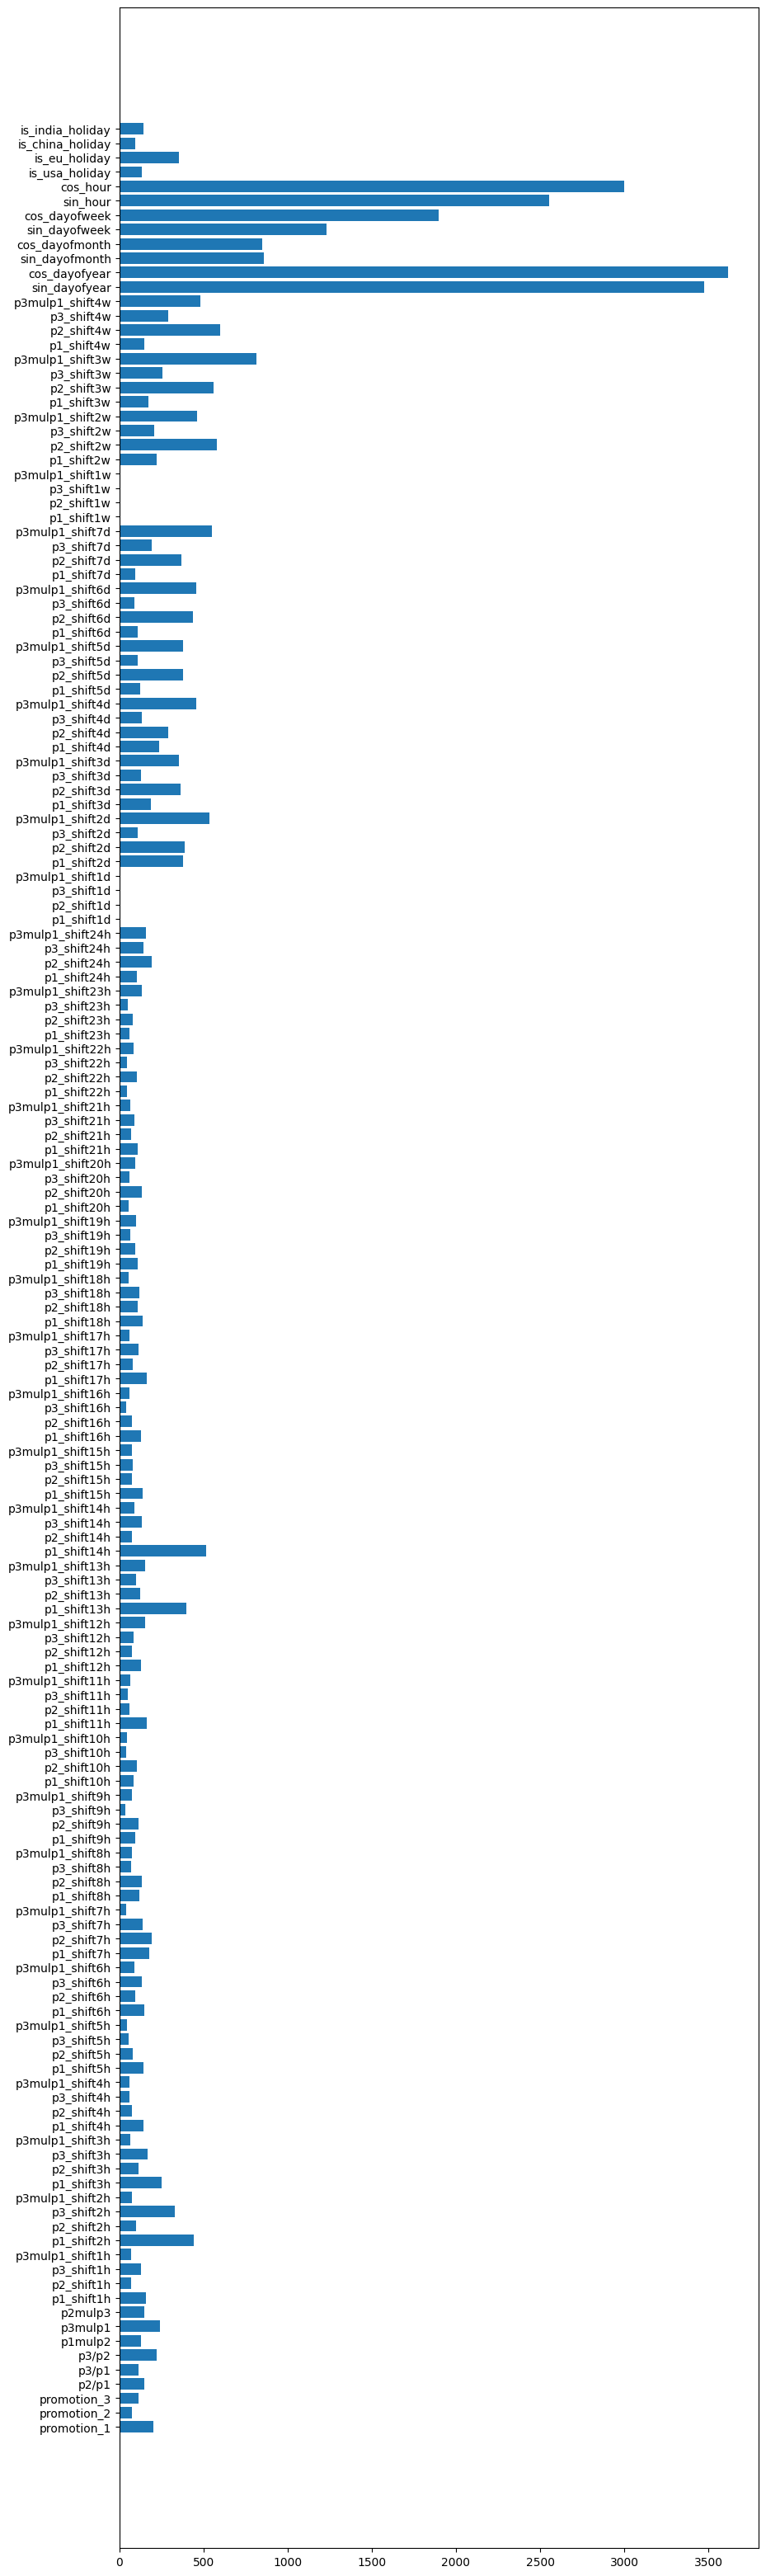

In [68]:
# 特徴量重要度
plt.figure(figsize=(10, 40))
feature_importance = pd.DataFrame(lgbm_model.feature_importances_, index=X_train.columns, columns=['importance'])
feature_importance.sort_values('importance', ascending=False)
plt.barh(feature_importance.index, feature_importance['importance'])
plt.show()

# .

In [69]:
submission = pd.read_csv('/content/drive/MyDrive/Kaggle/Prediction_of_E-commerce_Users/submission.csv')
submission

,datetime,e_users
0,2024-09-01 00:00:00,0
1,2024-09-01 01:00:00,0
2,2024-09-01 02:00:00,0
3,2024-09-01 03:00:00,0
4,2024-09-01 04:00:00,0
...,...,...
2923,2024-12-31 19:00:00,0
2924,2024-12-31 20:00:00,0
2925,2024-12-31 21:00:00,0
2926,2024-12-31 22:00:00,0


In [70]:
ensemble_test_pred

array([10.69902169, 10.59679847, 10.56060933, ..., 11.11740235,
       11.09835486, 11.12480045])

In [71]:
pred_log_value = ensemble_test_pred
submission['e_users'] = np.exp(pred_log_value)

In [72]:
submission

,datetime,e_users
0,2024-09-01 00:00:00,44312.482715
1,2024-09-01 01:00:00,40006.550059
2,2024-09-01 02:00:00,38584.631422
3,2024-09-01 03:00:00,36606.997417
4,2024-09-01 04:00:00,35662.334896
...,...,...
2923,2024-12-31 19:00:00,73265.506831
2924,2024-12-31 20:00:00,70667.679514
2925,2024-12-31 21:00:00,67332.771906
2926,2024-12-31 22:00:00,66062.388809


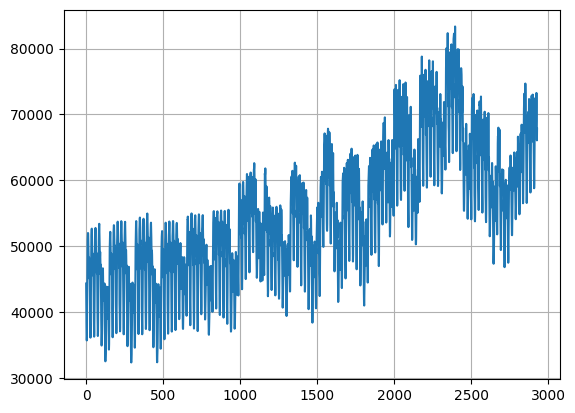

In [73]:
plt.plot(submission['e_users'])
plt.grid()
plt.show()

In [74]:
from google.colab import files
submission.to_csv('my_submission.csv', index=False)
files.download('my_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>